# Logistic Group Lasso Procedure to Predict Depression Diagnosis from Effective Network Connectivity


In [57]:
# Import necessary modules
import numpy as np
import pandas as pd
import group_lasso_cv as glcv
import matplotlib.pyplot as plt

# get the data
# Granger Causality
raw_df_gc = pd.read_csv("../yashoda_datasets_code/gc_network_wide_with_depression_filtered.tsv", delimiter="\t")
raw_df_gc.head()

# Functional Connectivity
raw_df_fc = pd.read_csv("../yashoda_datasets_code/fc_network_wide_with_depression_filtered.tsv", delimiter="\t")
raw_df_fc.head()



,ContA-ContA,ContA-ContB,ContA-ContC,ContA-DefaultA,ContA-DefaultB,ContA-DefaultC,ContA-DorsAttnA,ContA-DorsAttnB,ContA-LimbicA,ContA-LimbicB,...,SomMotB-VisCent,SomMotB-VisPeri,TempPar-TempPar,TempPar-VisCent,TempPar-VisPeri,VisCent-VisCent,VisCent-VisPeri,VisPeri-VisPeri,participant_id,depression_binary
0,0.273732,0.172078,0.106878,0.129903,0.131996,0.058273,-0.001047,0.049905,0.200008,0.077510,...,0.034618,0.081776,0.573154,0.107027,-0.045304,0.175083,0.110840,0.247207,sub-NDARINVAG023WG3,0.0
1,0.131507,0.119945,0.076551,0.091529,0.088947,0.076736,-0.029506,0.020395,0.111432,0.037152,...,0.040841,0.046227,0.492103,-0.033572,-0.113388,0.076237,0.074274,0.166691,sub-NDARINVAG339WHH,1.0
2,0.226729,0.122382,0.116056,0.090078,0.081285,-0.009408,0.002922,0.065142,0.241822,0.145142,...,0.005480,0.018669,0.345292,-0.057647,-0.029470,0.058999,0.020699,0.181377,sub-NDARINVAG388HJL,0.0
3,0.247755,0.184123,0.118441,0.117472,0.142211,0.129737,-0.119679,0.026731,0.220442,0.119099,...,0.021171,0.046652,0.522586,-0.046112,-0.107993,0.058340,0.052428,0.243354,sub-NDARINVAG900RVD,0.0
4,0.246889,0.111897,0.081103,0.140253,0.133968,0.007602,0.007258,0.030963,0.246845,0.171204,...,0.032730,0.084560,0.412784,-0.016155,-0.079451,0.066625,0.049464,0.285858,sub-NDARINVAH529JMM,0.0


## Functional Connectivity

In [58]:
def classify_fc_column(col):
    
    from itertools import combinations 
    groups = ['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'TempPar', 'Vis']
    pairs = list(combinations(groups, 2))
    [pairs.append((n, n)) for n in groups]
    labels = [a + '-' + b for a,b in pairs]

    group_dict = {}
    for ii, pairN in enumerate(pairs):
        isPairN = [np.logical_and(pairN[0] in colN, pairN[1] in colN) for colN in col]
        group_dict[f'{pairN[0]}-{pairN[1]}-FC'] = list(col[isPairN])
        

    return group_dict

col = np.array(raw_df_fc.columns)
group_dict_fc = classify_fc_column(col)

raw_df = raw_df_fc.drop('participant_id',axis=1)
X, y, groups = glcv.prepare_group_lasso_data(raw_df, group_dict_fc, target_col='depression_binary')

Step 2: Preparing data and group structure...
   - Converted group dictionary to a numerical array of length 153.
------------------------------


In [59]:
# Determine the hyperparameter search space
# Define the range of regularization strengths to test.
param_grid = {
    'group_reg': np.logspace(-15, 1, 10) # 10 values from 0.01 to 10
}
param_grid

{'group_reg': array([1.00000000e-15, 5.99484250e-14, 3.59381366e-12, 2.15443469e-10,
        1.29154967e-08, 7.74263683e-07, 4.64158883e-05, 2.78255940e-03,
        1.66810054e-01, 1.00000000e+01])}

In [60]:
# --- Step 4: Run Hold-Out Evaluation ---
# This function splits data into a train/test set, finds the best hyperparameters
# on the train set using CV, and evaluates the final model on the hold-out test set.
final_model, preprocessor, report, eval_data = glcv.run_holdout_evaluation(
    X, y, groups, param_grid, test_size=0.5, cv = 10, random_state=132
)

# Unpack the evaluation data for plotting
y_test, y_pred, y_pred_proba = eval_data

Step 4: Running Hold-Out Evaluation...
   - Data split into 111 training samples and 111 test samples.
   - Scaler fitted on training data and applied to both sets.
   - Tuning hyperparameters with GridSearchCV on the training data...
   - Best hyperparameter found: {'group_reg': 1e-15}
   - Best CV score on training data: 0.5821
   - Evaluating final model on the hold-out test set.


In [61]:
# %%
# --- [Cell 6] Step 5: Display Final Performance on Test Set ---
print("\n" + "-" * 30)
print("Step 5: Final Model Performance on Hold-Out Test Set")
print("\nPerformance Report:")
for metric, value in report.items():
    print(f"   - {metric}: {value:.4f}")

# Get and print the feature groups selected by the final model
selected_groups = glcv.get_selected_groups(final_model, groups, group_dict_fc)
print("\nSelected Feature Groups:")
if selected_groups:
    for group_name in selected_groups:
        print(f"   - {group_name}")
else:
    print("   - No groups were selected (all coefficients are zero).")



------------------------------
Step 5: Final Model Performance on Hold-Out Test Set

Performance Report:
   - Accuracy: 0.6126
   - Precision: 0.5000
   - Recall: 0.0233
   - F1-Score: 0.0444
   - ROC AUC: 0.6570

Selected Feature Groups:
   - Cont-Cont-FC
   - Default-Default-FC
   - Limbic-Limbic-FC
   - Vis-Vis-FC



------------------------------
Step 5: Final Model Performance on Hold-Out Test Set

Performance Report:
   - Accuracy: 0.6126
   - Precision: 0.5000
   - Recall: 0.0233
   - F1-Score: 0.0444
   - ROC AUC: 0.6570

Selected Feature Groups:
   - Cont-Cont-FC
   - Default-Default-FC
   - Limbic-Limbic-FC
   - Vis-Vis-FC

Displaying Confusion Matrix...


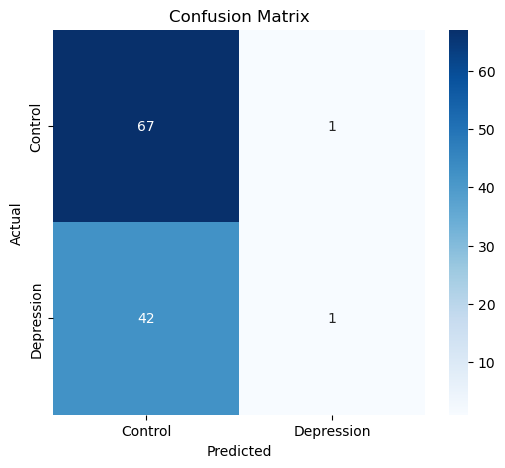


Displaying ROC Curve...


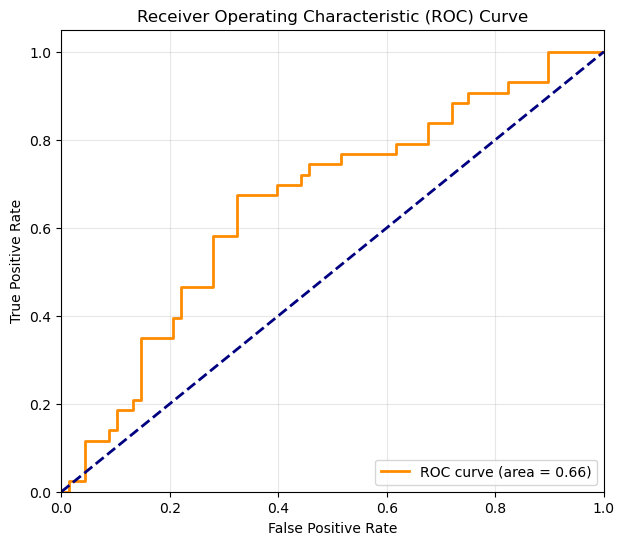


------------------------------
Analysis complete.


In [62]:
# %%
# --- [Cell 6] Step 5: Display Final Performance on Test Set ---
print("\n" + "-" * 30)
print("Step 5: Final Model Performance on Hold-Out Test Set")
print("\nPerformance Report:")
for metric, value in report.items():
    print(f"   - {metric}: {value:.4f}")

# Get and print the feature groups selected by the final model
selected_groups = glcv.get_selected_groups(final_model, groups, group_dict_fc)
print("\nSelected Feature Groups:")
if selected_groups:
    for group_name in selected_groups:
        print(f"   - {group_name}")
else:
    print("   - No groups were selected (all coefficients are zero).")


# %%
# --- [Cell 7] Step 6: Visualize Final Model Performance ---

# Plot the confusion matrix using the actual vs. predicted values from the test set
print("\nDisplaying Confusion Matrix...")
glcv.plot_confusion_matrix(y_test, y_pred, class_names=['Control', 'Depression'])

# Plot the ROC curve using the probabilities from the test set
print("\nDisplaying ROC Curve...")
glcv.plot_roc_curve(y_test, y_pred_proba)

print("\n" + "-" * 30)
print("Analysis complete.")


## Granger Causality

In [63]:
from collections import defaultdict
raw_df = raw_df_gc
# Create a defaultdict that will create an empty list for any new key
grouped_dict = defaultdict(list)
# Prepare feature matrix, and group labels
X = raw_df.copy().drop(['participant_id','depression_binary'], axis=1)
y = raw_df['depression_binary'].copy()

# Group labels are the first network in the column names
group_labels = [(colN.split('-')[0], colN) for colN in X.columns]
[grouped_dict[keyN].append(valN) for keyN, valN in group_labels];
group_labels = np.array(group_labels)[:,0]
groups = np.unique(group_labels, return_inverse=True)[1]

In [64]:
# --- Run Hold-Out Evaluation ---
# This function splits data into a train/test set, finds the best hyperparameters
# on the train set using CV, and evaluates the final model on the hold-out test set.
final_model, preprocessor, report, eval_data = glcv.run_holdout_evaluation(
    X, y, groups, param_grid, test_size=0.5, cv = 10
)

# Unpack the evaluation data for plotting
y_test, y_pred, y_pred_proba = eval_data

Step 4: Running Hold-Out Evaluation...
   - Data split into 111 training samples and 111 test samples.
   - Scaler fitted on training data and applied to both sets.
   - Tuning hyperparameters with GridSearchCV on the training data...
   - Best hyperparameter found: {'group_reg': 1e-15}
   - Best CV score on training data: 0.5357
   - Evaluating final model on the hold-out test set.


In [67]:
# %%
# --- [Cell 6] Step 5: Display Final Performance on Test Set ---
print("\n" + "-" * 30)
print("Step 5: Final Model Performance on Hold-Out Test Set")
print("\nPerformance Report:")
for metric, value in report.items():
    print(f"   - {metric}: {value:.4f}")

# Get and print the feature groups selected by the final model
selected_groups = glcv.get_selected_groups(final_model, groups, grouped_dict)
print("\nSelected Feature Groups:")
if selected_groups:
    for group_name in selected_groups:
        print(f"   - {group_name}")
else:
    print("   - No groups were selected (all coefficients are zero).")



------------------------------
Step 5: Final Model Performance on Hold-Out Test Set

Performance Report:
   - Accuracy: 0.5856
   - Precision: 0.0000
   - Recall: 0.0000
   - F1-Score: 0.0000
   - ROC AUC: 0.5055

Selected Feature Groups:
   - DefaultB
   - DorsAttnA
   - LimbicB
   - SalVentAttnA
   - TempPar
   - VisPeri



------------------------------
Step 5: Final Model Performance on Hold-Out Test Set

Performance Report:
   - Accuracy: 0.5856
   - Precision: 0.0000
   - Recall: 0.0000
   - F1-Score: 0.0000
   - ROC AUC: 0.5055

Selected Feature Groups:
   - Cont-SalVentAttn-FC
   - Cont-TempPar-FC
   - Default-DorsAttn-FC
   - Default-Limbic-FC
   - Default-Vis-FC
   - DorsAttn-Limbic-FC

Displaying Confusion Matrix...


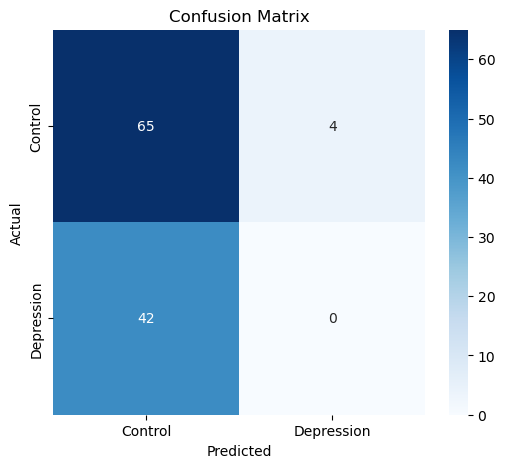


Displaying ROC Curve...


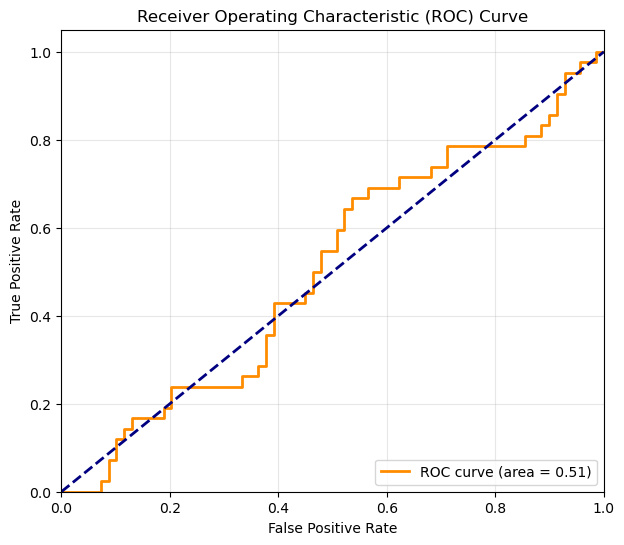


------------------------------
Analysis complete.


In [68]:
# %%
# --- [Cell 6] Step 5: Display Final Performance on Test Set ---
print("\n" + "-" * 30)
print("Step 5: Final Model Performance on Hold-Out Test Set")
print("\nPerformance Report:")
for metric, value in report.items():
    print(f"   - {metric}: {value:.4f}")

# Get and print the feature groups selected by the final model
selected_groups = glcv.get_selected_groups(final_model, groups, group_dict_fc)
print("\nSelected Feature Groups:")
if selected_groups:
    for group_name in selected_groups:
        print(f"   - {group_name}")
else:
    print("   - No groups were selected (all coefficients are zero).")


# %%
# --- [Cell 7] Step 6: Visualize Final Model Performance ---

# Plot the confusion matrix using the actual vs. predicted values from the test set
print("\nDisplaying Confusion Matrix...")
glcv.plot_confusion_matrix(y_test, y_pred, class_names=['Control', 'Depression'])

# Plot the ROC curve using the probabilities from the test set
print("\nDisplaying ROC Curve...")
glcv.plot_roc_curve(y_test, y_pred_proba)

print("\n" + "-" * 30)
print("Analysis complete.")


# Combined